In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import os 
import multiprocessing
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={10}"
jax.config.update('jax_platform_name', 'cpu')
platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)
print(len(jax.devices()))

Platform:  cpu
28


In [56]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.confs.utils import omega

from cohlib.utils import rotate_eigvecs, naive_estimator
import cohlib.confs.utils as conf

In [60]:
gamma_seed = 0
def temp_func(K, L, seed, mu, rank='rank1', gamma_seed=0):
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    latent_load = pickle_open(latent_path)
    return latent_load['lcfg']


def get_sim_gamma_ests(K, L, seed, mu, rank='rank1', gamma_seed=0):
    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    obs_load = pickle_open(obs_path)
    latent_load = pickle_open(latent_path)

    obs = obs_load['obs']
    zs_nz = latent_load['zs_nz']

    lcfg = conf.omega(latent_load['lcfg'])
    lrccn_true = conf.create_lrccn_basic_rank1(lcfg, print_seed=False)
    # gamma_true = lrccn_true.get_gamma()
    nz_model = jnp.array([lcfg.target_freq_ind])

    naive_est = naive_estimator(obs, nz_model)*1e6
    oracle_est = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)

    return lrccn_true, naive_est, oracle_est

def get_sim_ests(K, L, seed, mu, rank='rank1', gamma_seed=0):
    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    obs_load = pickle_open(obs_path)
    latent_load = pickle_open(latent_path)

    obs = obs_load['obs']
    zs_nz = latent_load['zs_nz']

    lcfg = conf.omega(latent_load['lcfg'])
    lrccn_true = conf.create_lrccn_basic_rank1(lcfg, print_seed=False)
    # gamma_true = lrccn_true.get_gamma()
    nz_model = jnp.array([lcfg.target_freq_ind])

    naive_est = naive_estimator(obs, nz_model)*1e6
    eigvals_naive_raw, eigvecs_naive_raw = jnp.linalg.eigh(naive_est)
    eigvals_naive = eigvals_naive_raw[:,::-1]
    eigvecs_naive = eigvecs_naive_raw[:,:,::-1]

    oracle_est = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigvals_oracle_raw, eigvecs_oracle_raw = jnp.linalg.eigh(oracle_est)
    eigvals_oracle = eigvals_oracle_raw[:,::-1]
    eigvecs_oracle = eigvecs_oracle_raw[:,:,::-1]

    return lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle


def get_fullrank_model_ests(K, L, seed, mu, init, rank='rank1', gamma_seed=0):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init_6.0/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)

    eigvals = get_eigvals(res_load['ccn_est'])
    eigvecs = get_eigvecs(res_load['ccn_est'])
    return eigvals, eigvecs

def get_lowrank_model_ests(K, L, seed, mu, init, rank='rank1', gamma_seed=0):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_6.0_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)
    lrccn_est = res_load['lrccn_est'] 
    return lrccn_est.eigvals, lrccn_est.eigvecs

    # eigvals = get_eigvals(res_load['ccn_est'])
    # eigvecs = get_eigvecs(res_load['ccn_est'])
    # return eigvals, eigvecs

In [58]:
def get_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

def get_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals


In [61]:
K = 3
L = 5
seed = 2
mu = 0.0
lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
lrccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu)
gamma_true = lrccn_true.get_gamma()

### what do we want to inspect? 
- relationship between behavior of naive estimator and fullrank/lowrank model behavior 

In [62]:
def get_eigval_sim_model_results(model_load_func, mu, L, init, legend=False, num_samples=100):
    j = 0
    eigrank = 1
    K = 3
    naive_ests = jnp.zeros(num_samples)
    oracle_ests = jnp.zeros(num_samples)
    model_ests = jnp.zeros(num_samples)
    true_vals = jnp.zeros(num_samples)

    for seed in range(0, num_samples):
        lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
        eigvals_model, eigvecs_model = model_load_func(K, L, seed, mu, init)

        naive_ests = naive_ests.at[seed].set(eigvals_naive[j,eigrank-1])
        oracle_ests = oracle_ests.at[seed].set(eigvals_oracle[j,eigrank-1])
        model_ests = model_ests.at[seed].set(eigvals_model[j,eigrank-1])
        true_vals = true_vals.at[seed].set((lrccn_true.eigvals[j,eigrank-1]))

    return true_vals, naive_ests, oracle_ests, model_ests

def get_eigvec_sim_model_results(model_load_func, func, dim, mu, L, init, legend=False, num_samples=100):
    j = 0
    eigrank = 1
    K = 3

    naive_ests = jnp.zeros(num_samples)
    oracle_ests = jnp.zeros(num_samples)
    model_ests = jnp.zeros(num_samples)
    true_vals = jnp.zeros(num_samples)
    for seed in range(0, num_samples):
        lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
        eigvals_model, eigvecs_model = model_load_func(K, L, seed, mu, init)

        naive_ests = naive_ests.at[seed].set(func(rotate_eigvecs(eigvecs_naive)[j,dim,eigrank-1]))
        oracle_ests = oracle_ests.at[seed].set(func(rotate_eigvecs(eigvecs_oracle)[j,dim,eigrank-1]))
        model_ests = model_ests.at[seed].set(func(rotate_eigvecs(eigvecs_model)[j,dim,eigrank-1]))
        true_vals = true_vals.at[seed].set(func(rotate_eigvecs(lrccn_true.eigvecs)[j,dim,eigrank-1]))

    return true_vals, naive_ests, oracle_ests, model_ests

In [63]:
L = 3
mu = -2.0
model_func = get_fullrank_model_ests
true_eigvals, naive_eigvals, oracle_eigvals, model_eigvals = get_eigval_sim_model_results(model_func, mu, L, init='empirical', num_samples=20)

In [69]:
def get_fullrank_model_emtrack(K, L, seed, mu, init, rank='rank1', gamma_seed=0):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init_6.0/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)

    track = res_load['track']
    return track

def get_lowrank_model_emtrack(K, L, seed, mu, init, rank='rank1'):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_6.0_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rank}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)
    track = res_load['track'] 
    return track

In [70]:
K = 3
L = 5
seed = 0
mu = 0.0
init = 'empirical'

track = get_fullrank_model_emtrack(K, L, seed, mu, init)

In [71]:
j = 0
jnp.stack([get_eigvals(x)[j,0] for x in track['ccn']])

Array([18329170. ,  4237398. ,  3991038.2,  3919104. ,  3908584.5,
        3922211.5,  3940077. ,  3956060. ,  3969262. ,  3980055. ,
        3988951.8,  3996381.8,  4002664. ,  4008037. ,  4012680.8,
        4016730.2,  4020290. ,  4023440.5,  4026248. ,  4028761. ,
        4031023.2], dtype=float32)

In [72]:
eigvals_naive

Array([[5592531. , 2104149. ,  324552.7]], dtype=float32)

In [73]:
def plot_sim_eigvals_hline(ax, K, L, seed, mu, eigrank=1):
    lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
    ax.axhline(eigvals_naive[j,eigrank-1], color='tab:red')
    ax.axhline(eigvals_oracle[j,eigrank-1], color='tab:green')
    ax.axhline(lrccn_true.eigvals[j,eigrank-1], color='k')

def plot_eigvals_fullrank_em(ax, init, K, L, seed, mu, eigrank=1):
    j = 0
    fullrank_track = get_fullrank_model_emtrack(K, L, seed, mu, init)
    eigvals_em = jnp.stack([get_eigvals(x)[j,eigrank-1] for x in fullrank_track['ccn']])
    
    ax.plot(eigvals_em, color='tab:blue')

def plot_eigvals_lowrank_em(ax, init, K, L, seed, mu, eigrank=1):
    j = 0
    lowrank_track = get_lowrank_model_emtrack(K, L, seed, mu, init)
    eigvals_em = jnp.stack([x.eigvals[j,eigrank-1] for x in lowrank_track['lrccn']])
    
    ax.plot(eigvals_em, linestyle='--', color='tab:blue')

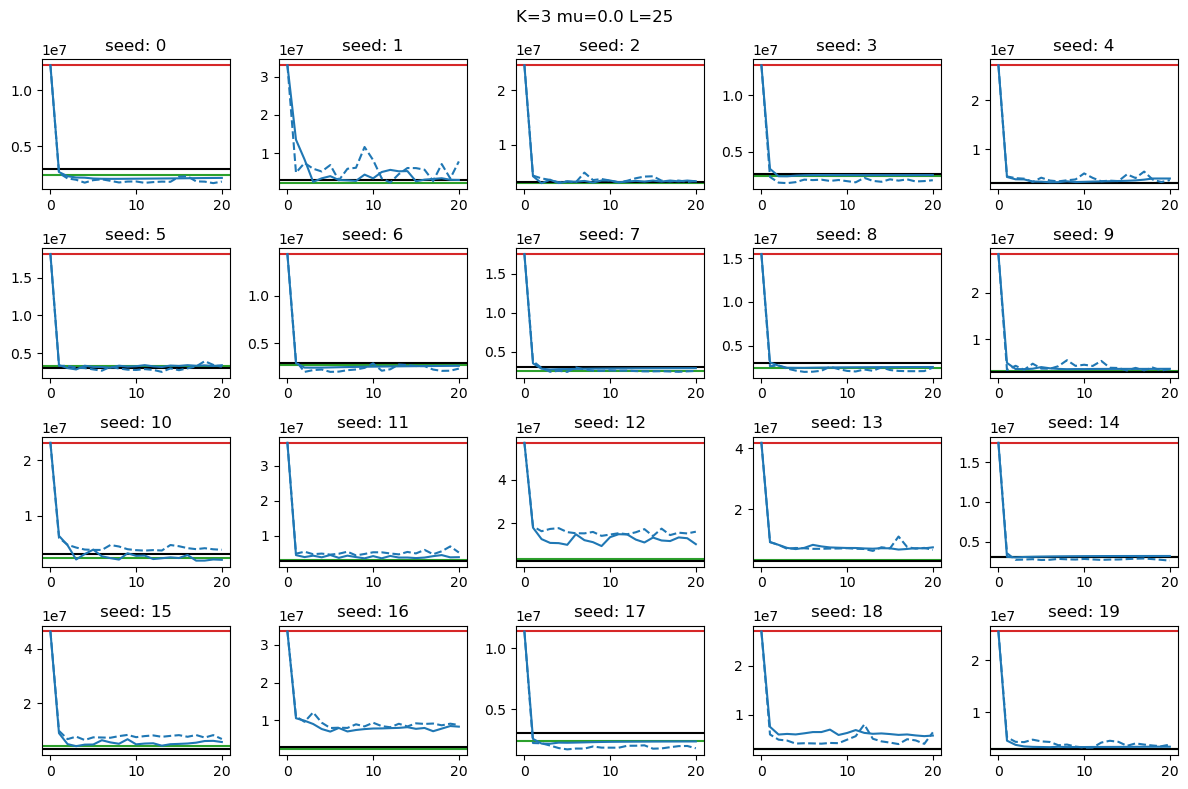

In [75]:
K = 3
L = 25
seed = 0
mu = 0.0
# fig, ax = plt.subplots(3,3,figsize=(5,3))
fig = plt.figure(figsize=(12,8))
start = 0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvals_hline(ax, K, L, seed, mu)
    plot_eigvals_fullrank_em(ax, 'empirical', K, L, seed, mu)
    plot_eigvals_lowrank_em(ax, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

In [76]:
def plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu, eigrank=1):
    j = 0
    lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
    ax.axhline(func(rotate_eigvecs(lrccn_true.eigvecs)[j,dim,eigrank-1]), color='k')
    ax.axhline(func(rotate_eigvecs(eigvecs_oracle)[j,dim,eigrank-1]), color='tab:green', linestyle='-.')
    ax.axhline(func(rotate_eigvecs(eigvecs_naive)[j,dim,eigrank-1]), color='tab:red')

def plot_eigvecs_fullrank_em(ax, func, dim, init, K, L, seed, mu, eigrank=1):
    j = 0
    fullrank_track = get_fullrank_model_emtrack(K, L, seed, mu, init)
    eigvecs_em = jnp.stack([rotate_eigvecs(get_eigvecs(x))[j,dim,eigrank-1] for x in fullrank_track['ccn']])
    
    ax.plot(func(eigvecs_em), color='tab:blue')

def plot_eigvecs_lowrank_em(ax, func, dim, init, K, L, seed, mu, eigrank=1):
    j = 0
    lowrank_track = get_lowrank_model_emtrack(K, L, seed, mu, init)
    eigvecs_em = jnp.stack([rotate_eigvecs(x.eigvecs)[j,dim,eigrank-1] for x in lowrank_track['lrccn']])
    
    ax.plot(func(eigvecs_em), linestyle='--', color='tab:blue')

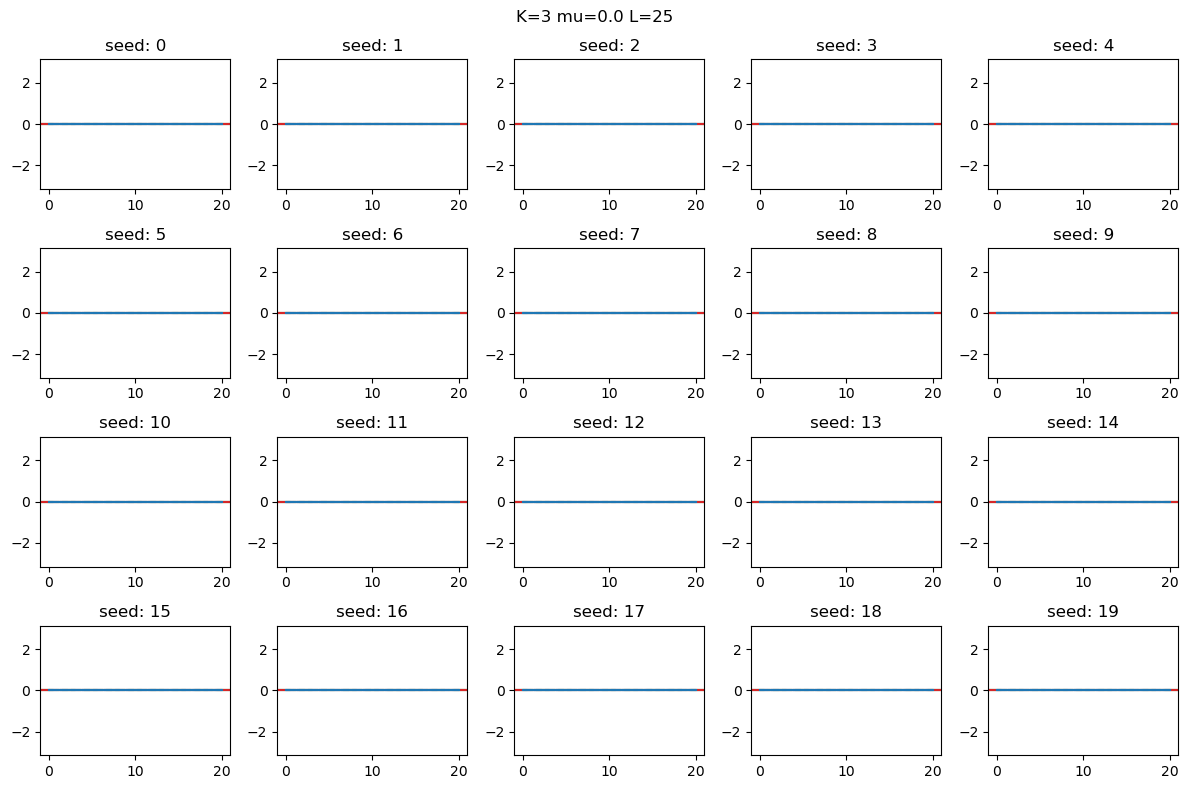

In [77]:
func = jnp.angle
dim = 0
fig = plt.figure(figsize=(12,8))
start = 0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu)
    plot_eigvecs_fullrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    plot_eigvecs_lowrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
    if func == jnp.angle:
        ax.set_ylim([-jnp.pi, jnp.pi])
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

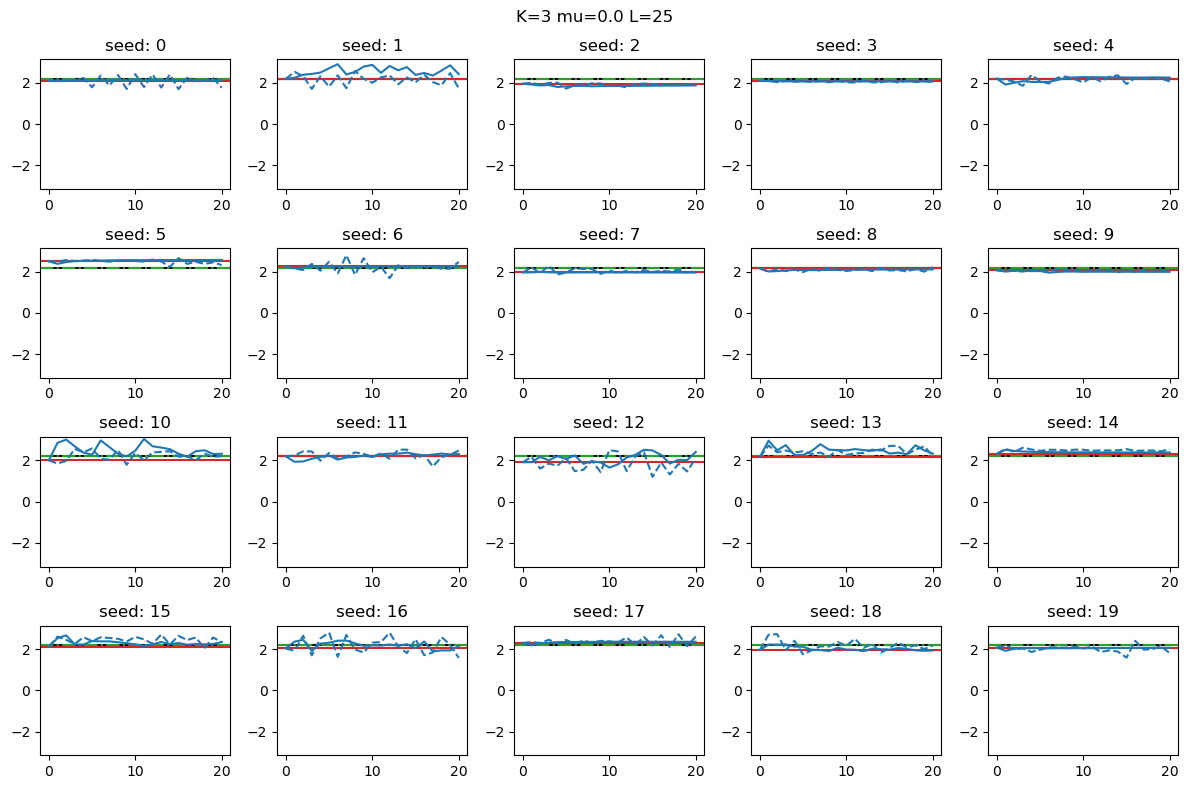

In [80]:
func = jnp.angle
dim = 1
fig = plt.figure(figsize=(12,8))
start = 0
mu = 0.0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu)
    plot_eigvecs_fullrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    plot_eigvecs_lowrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
    if func == jnp.angle:
        ax.set_ylim([-jnp.pi, jnp.pi])
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

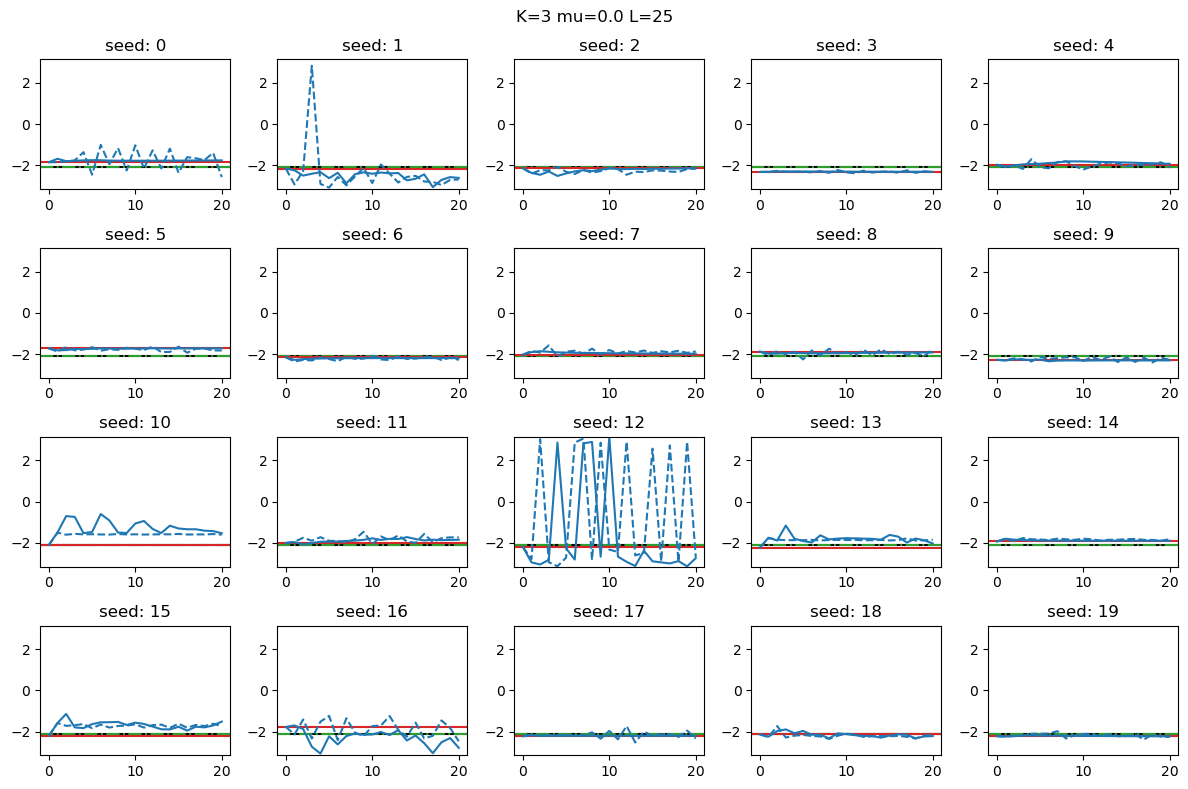

In [79]:
func = jnp.angle
dim = 2
fig = plt.figure(figsize=(12,8))
start = 0
mu = 0.0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu)
    plot_eigvecs_fullrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    plot_eigvecs_lowrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
    if func == jnp.angle:
        ax.set_ylim([-jnp.pi, jnp.pi])
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

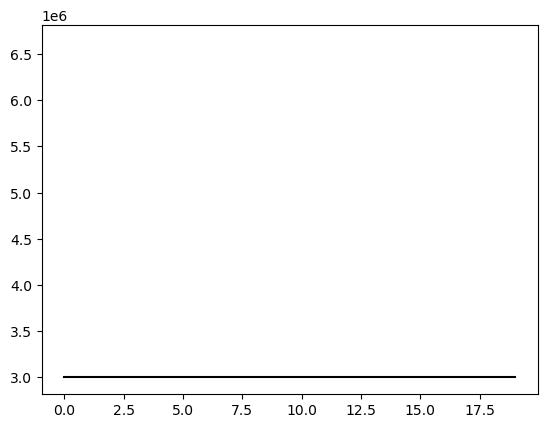

In [34]:
plt.plot(true_eigvals, color='k')
# plt.plot(naive_eigvals, color='tab:red')
# plt.plot(oracle_eigvals, color='tab:green')
plt.plot(model_eigvals, color='tab:blue')

In [31]:
model_func = get_fullrank_model_ests

Text(0.5, 0.98, 'Eigvals')

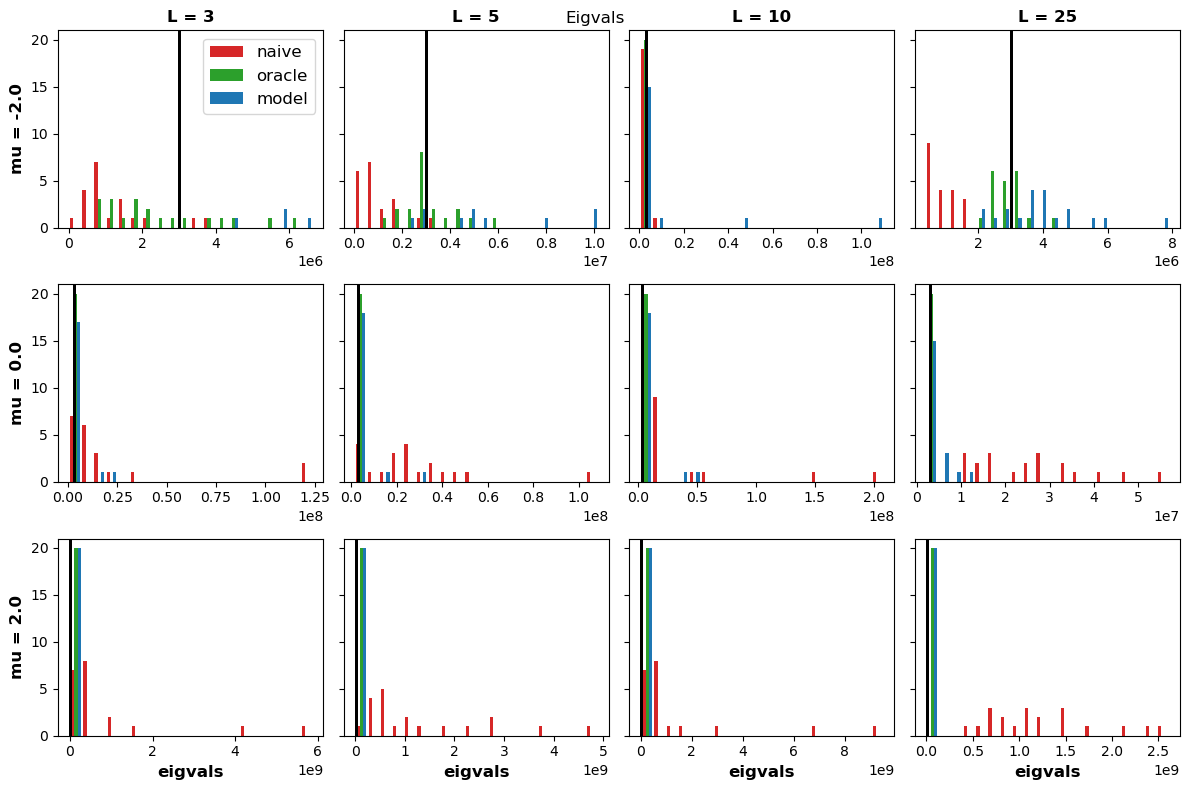

In [21]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigval_sim_model_hist(ax[m,ell], model_func, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
plt.tight_layout()
fig.suptitle('Eigvals')

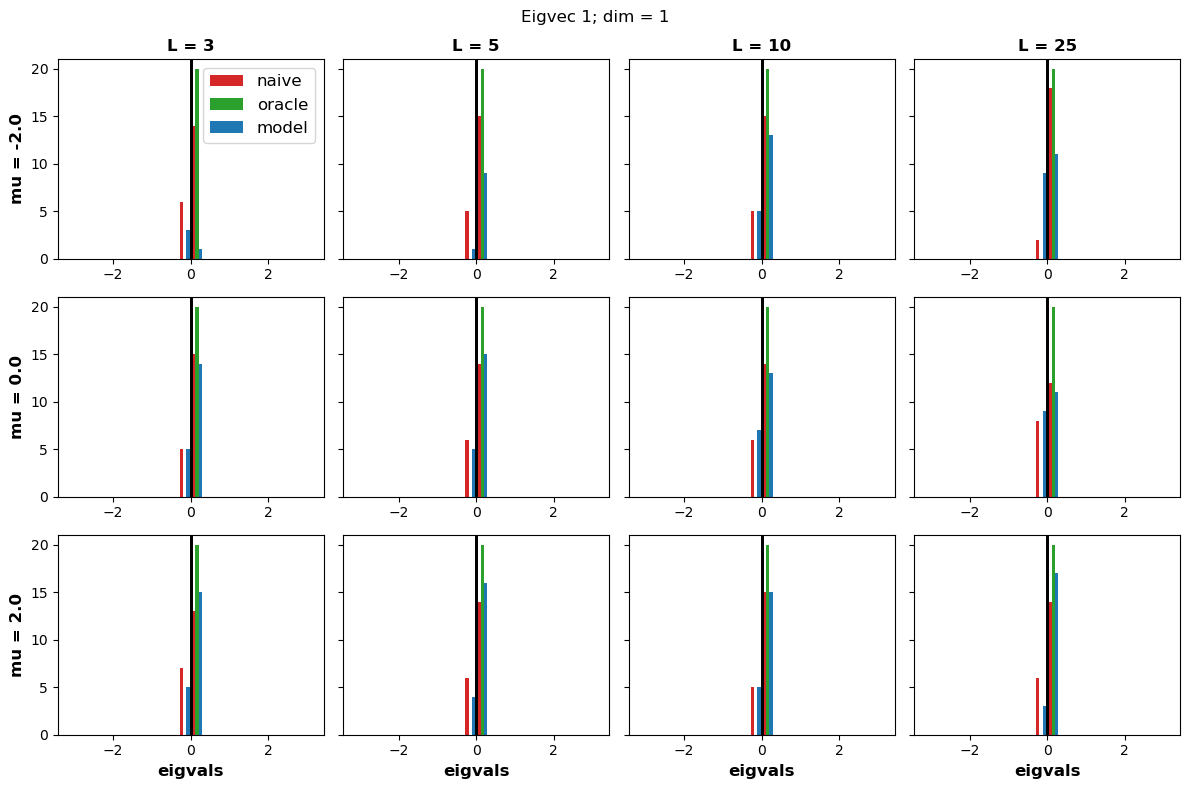

In [32]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 0
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

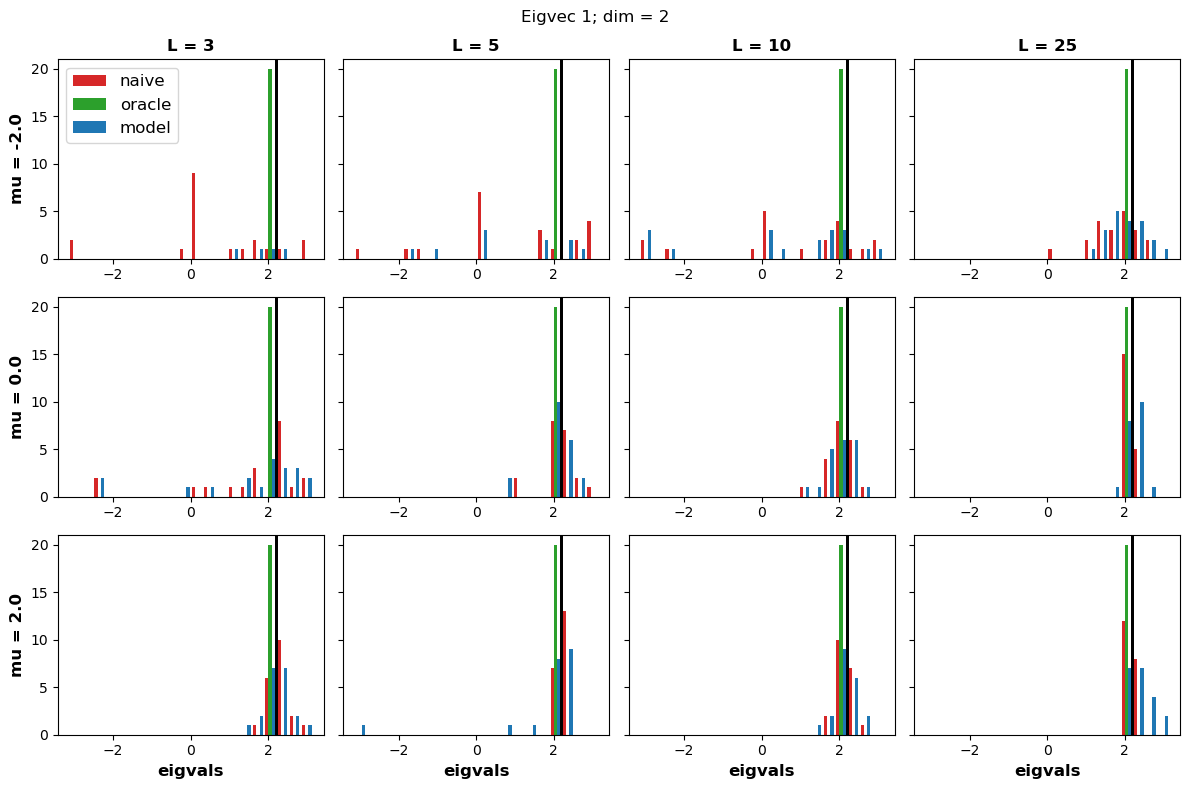

In [26]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 1
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

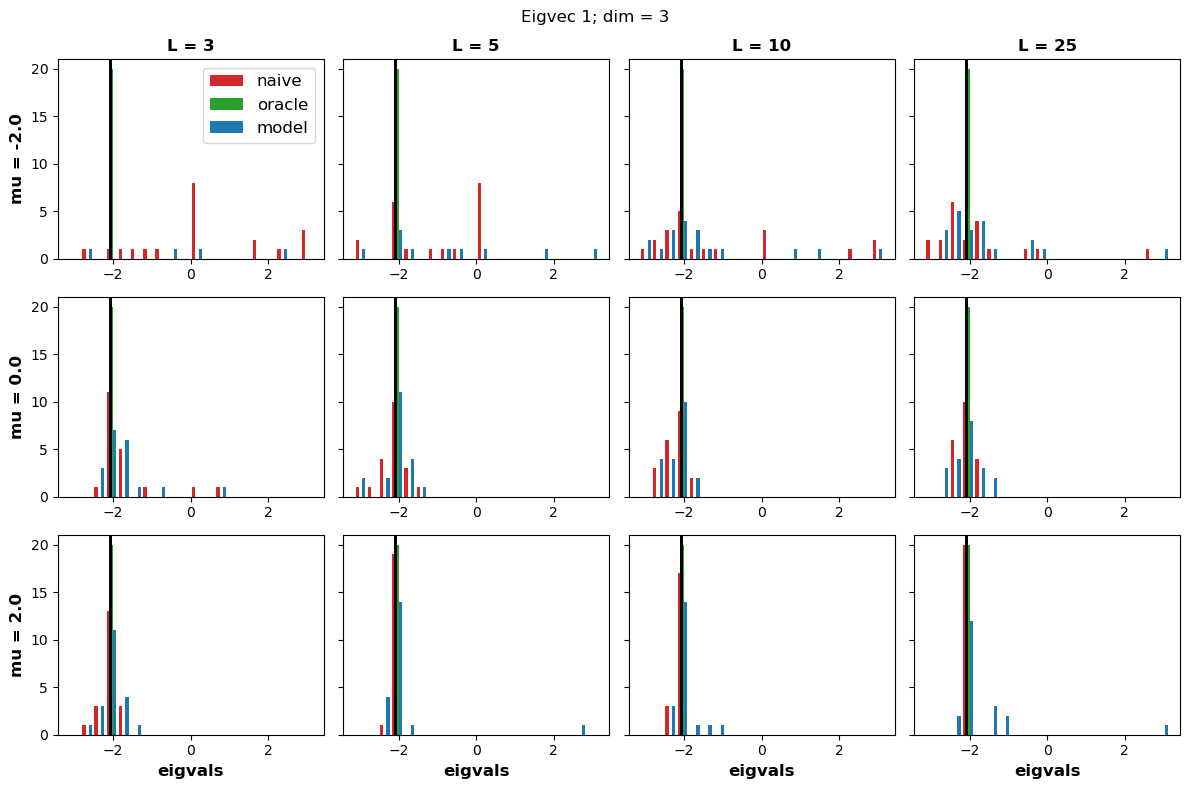

In [24]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 2
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

In [27]:
model_func = get_lowrank_model_ests

Text(0.5, 0.98, 'Eigvals')

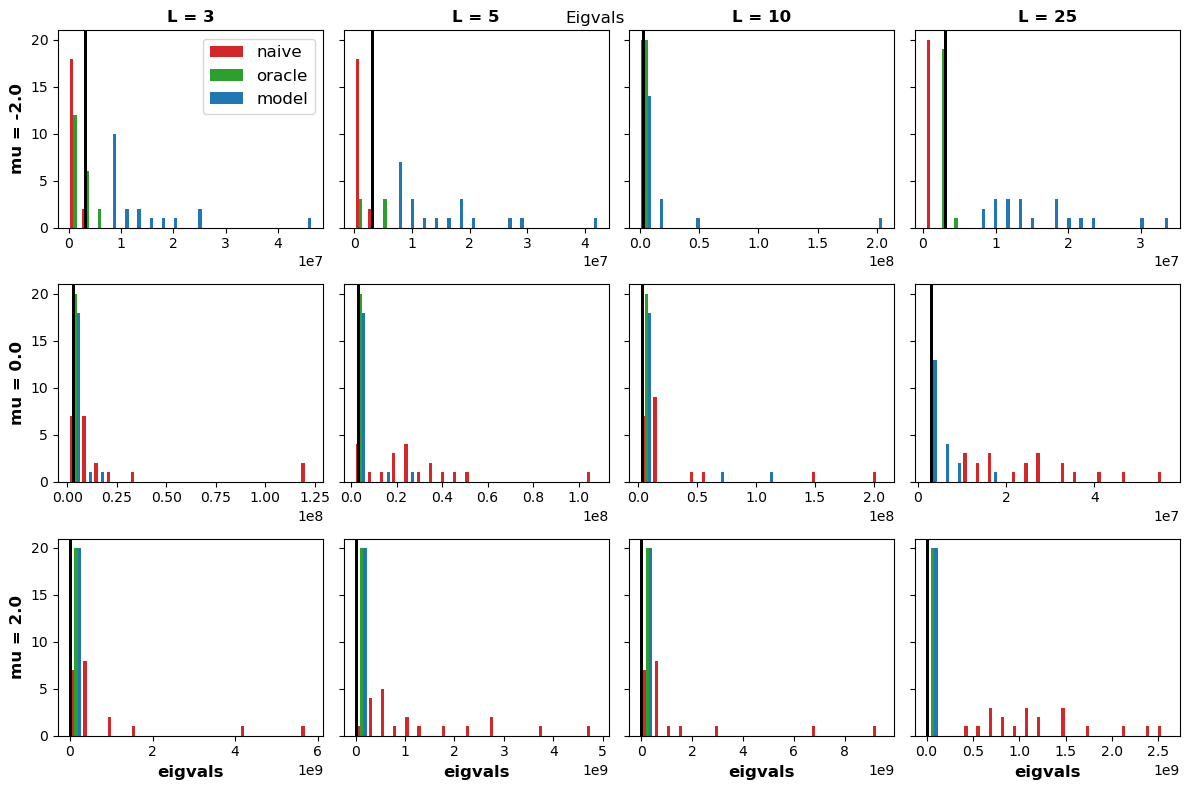

In [ ]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigval_sim_model_hist(ax[m,ell], model_func, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
plt.tight_layout()
fig.suptitle('Eigvals')

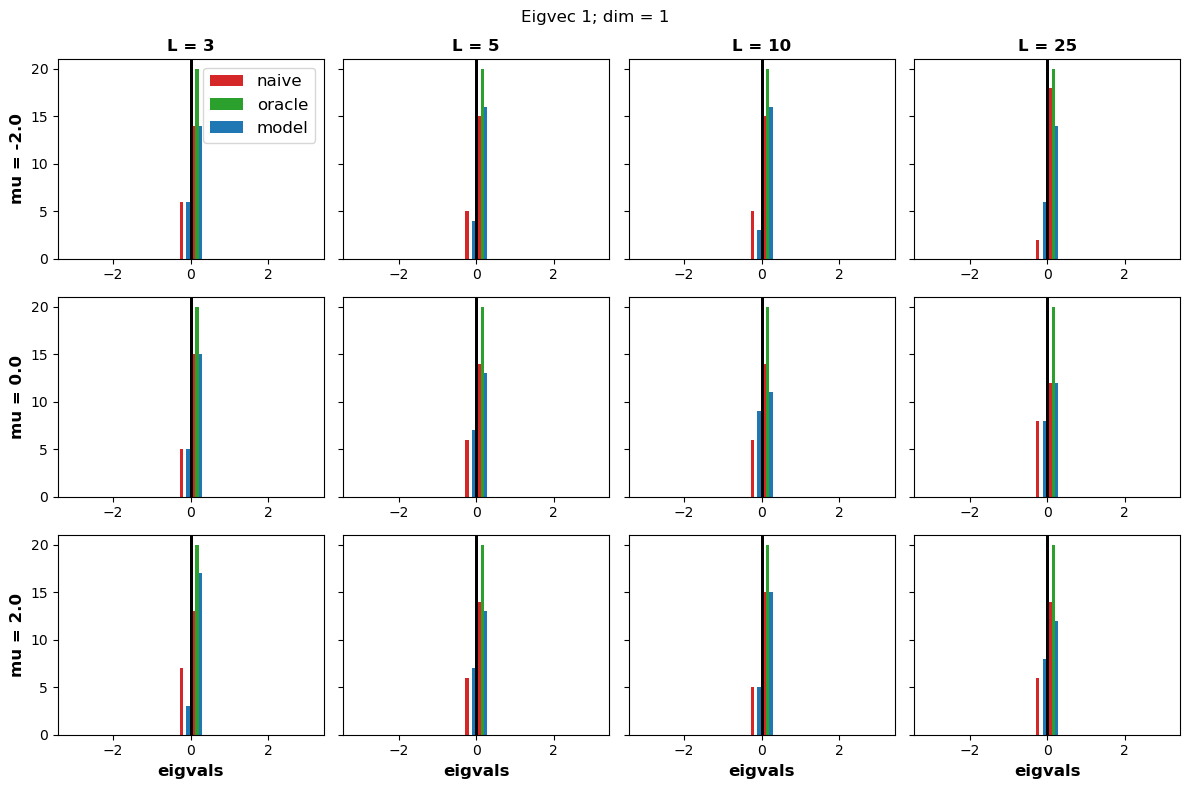

In [28]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 0
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

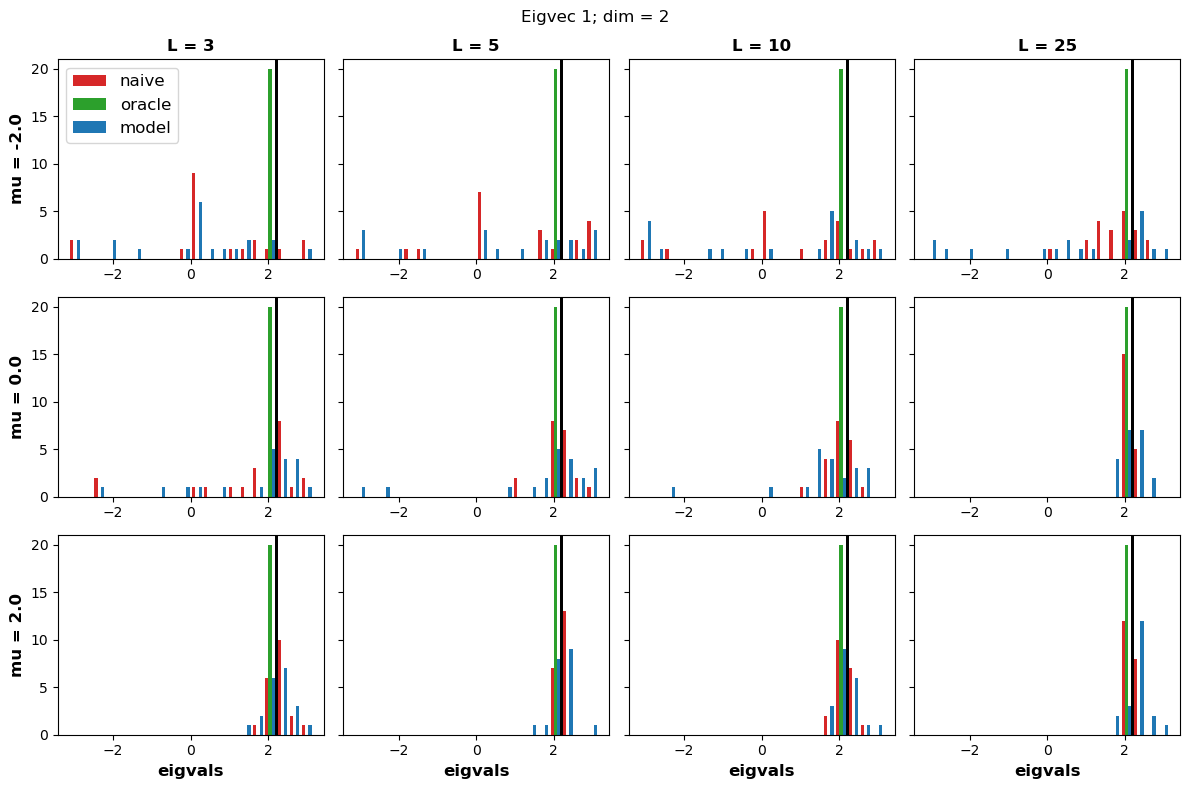

In [29]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 1
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

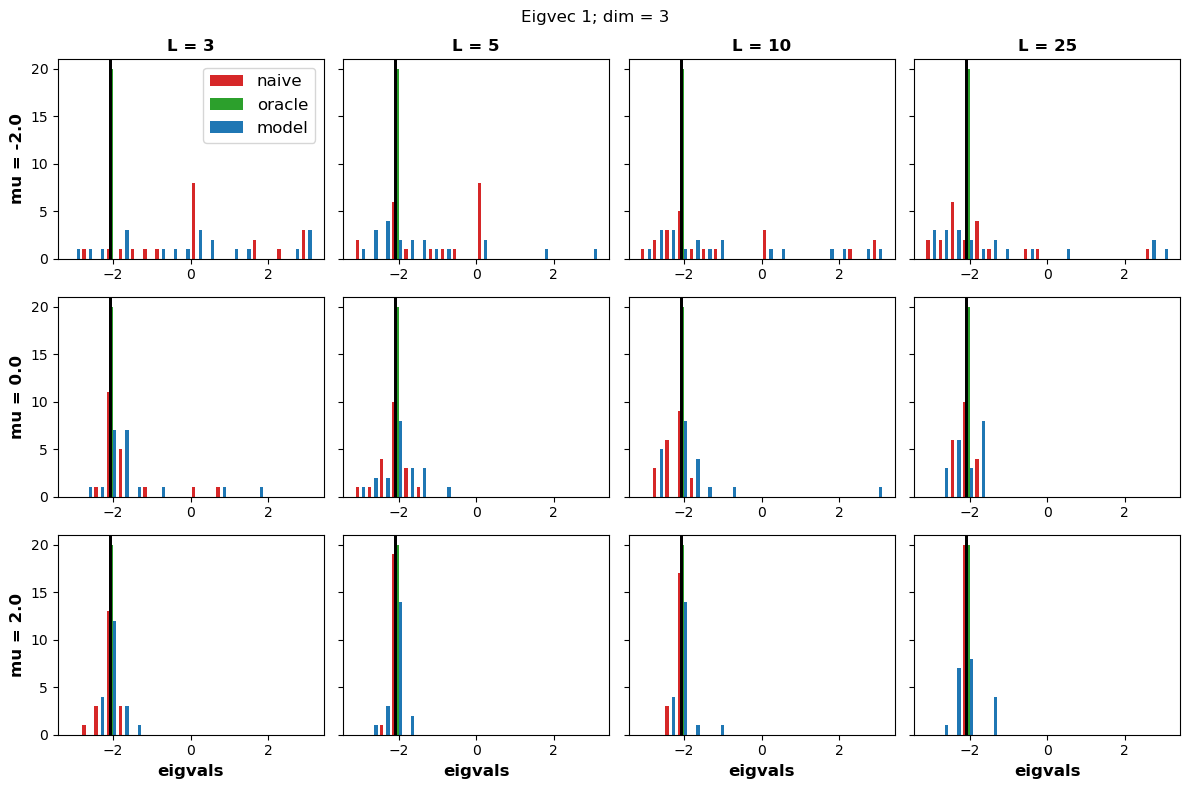

In [30]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 2
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

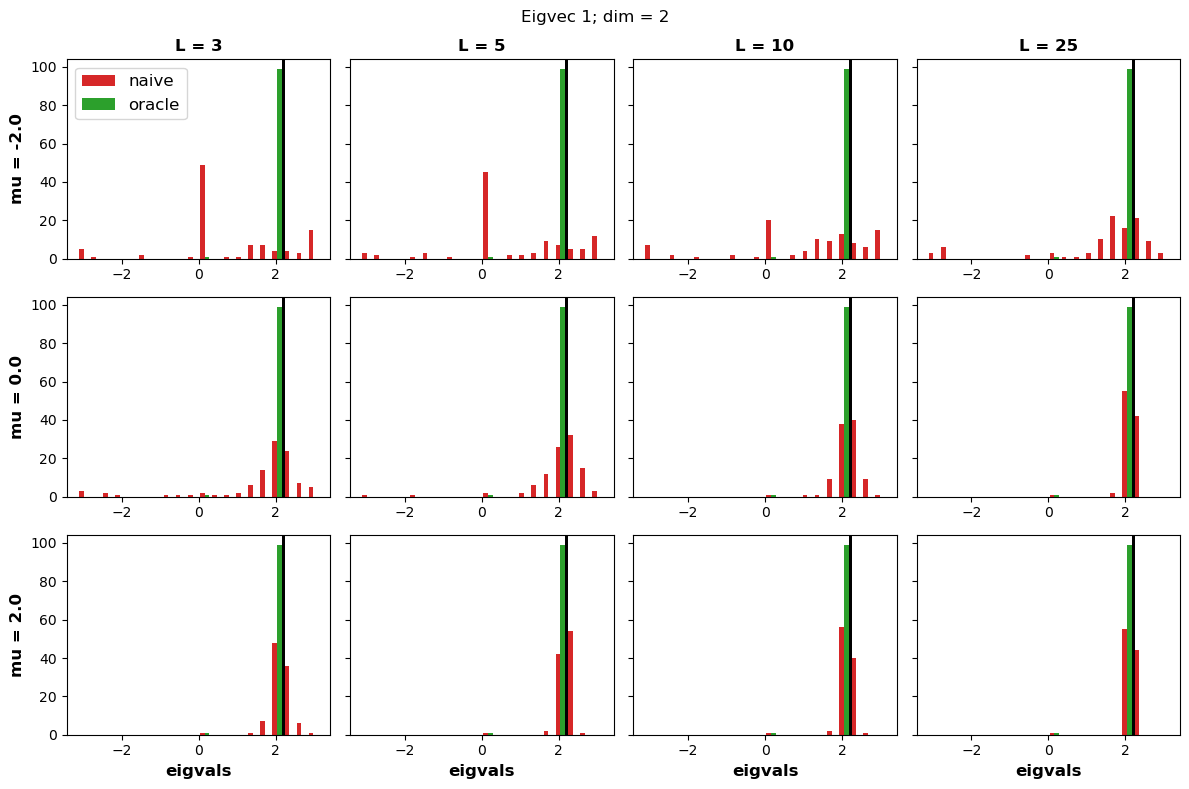

In [36]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 1
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_hist(ax[m,ell], jnp.angle, dim, mu, L, num_samples=100)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

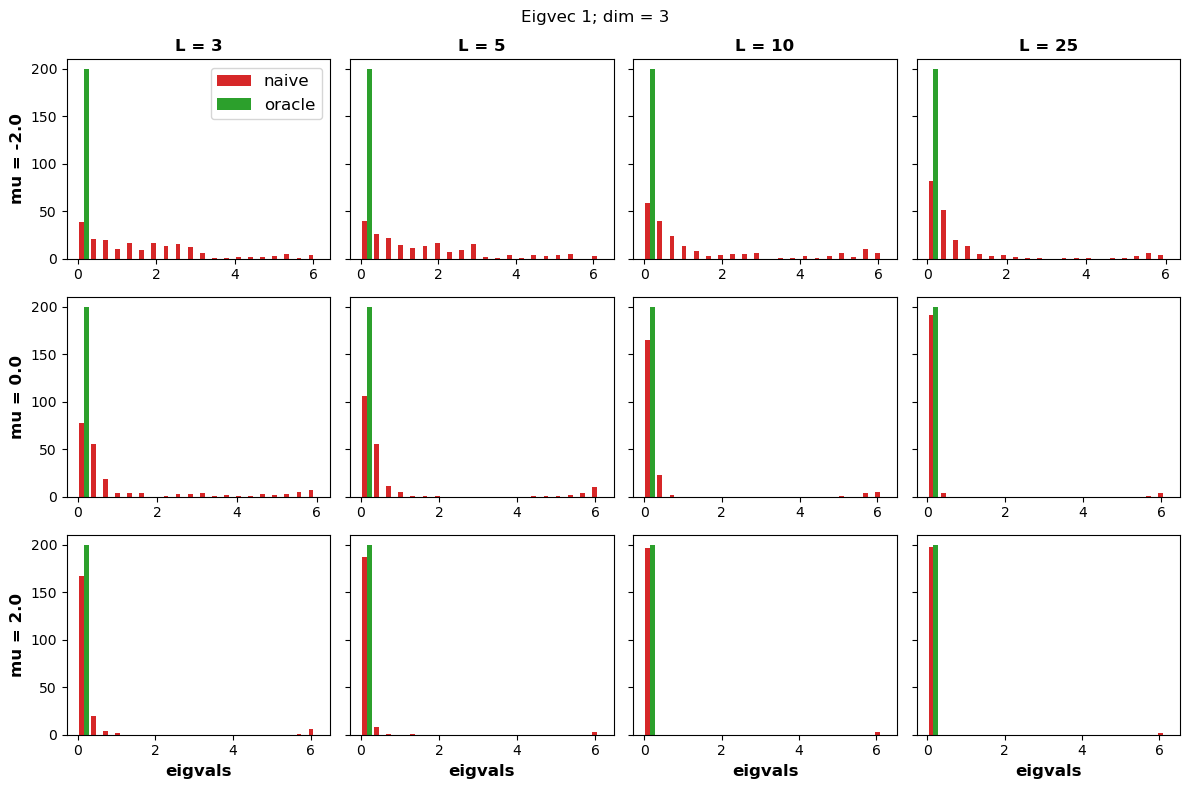

In [96]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 2
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_hist(ax[m,ell], jnp.angle, dim, mu, L, num_samples=200)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

In [18]:
lrccn_true.eigvecs.shape

(1, 3, 1)

In [19]:
eigvecs_naive.shape

(1, 3, 3)

In [7]:
test = get_sim_ests(3, 10, 1, 0.0)

In [8]:
test

{'lcfg': {'latent_type': 'basic_single_log',
  'K': 3,
  'rank': 1,
  'num_freqs': 500,
  'target_freq_ind': 9,
  'scale_power_target': 1000000.0,
  'L': 10,
  'seed': 1},
 'zs_nz': Array([[[  362.26822   -235.62419j ,  -539.15607   +902.07904j ,
            335.76718    +73.1075j  , -1022.34      -193.43161j ,
             -9.1434765 +246.87503j ,   -13.2654915 -233.41856j ,
            681.0582    -875.6936j  ,  -920.52734    +60.013958j,
            657.00446    +64.466606j,   196.70453   +474.23578j ],
         [ -352.357     -250.20302j ,  1037.1538    +169.55151j ,
            -55.521164  -339.11896j ,   196.17085  +1021.8178j  ,
            232.93108    -82.30427j ,  -212.17538    +98.192635j,
          -1064.8132    -311.21085j ,   394.3994    +833.9192j  ,
           -181.7153    -634.6576j  ,   368.6367    -357.35022j ],
         [   56.86154   +428.3968j  ,  -582.3992    -874.784j   ,
           -210.44145   +271.65915j ,   614.42114   -839.69135j ,
           -218.92978   -

In [4]:
# L = 10 
# ov2 = -1.0
K = 3
L = 10
seed = 1
mu = -1.0
init = 'empirical'
# res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-oracle_eigvecs-fit/newton-10_em-20/res.pkl'
if init == 'flat':
    res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init_6.0/newton-10_em-20/res.pkl'
if init == 'empirical':
    res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init/newton-10_em-20/res.pkl'
obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

# latent_load = pickle_open(latent_path)
# obs_load = pickle_open(obs_path)
res_load = pickle_open(res_path)
obs_load = pickle_open(obs_path)
latent_load = pickle_open(latent_path)

obs = obs_load['obs']
zs_nz = latent_load['zs_nz']
cfg = omega(res_load['cfg'])
lcfg = cfg.latent
nz_model = jnp.array([lcfg.target_freq_ind])

In [5]:
latent_load.keys()

dict_keys(['lcfg', 'zs_nz', 'nz', 'freqs'])

In [6]:
latent_load['lcfg']

{'latent_type': 'basic_single_log',
 'K': 3,
 'rank': 1,
 'num_freqs': 500,
 'target_freq_ind': 9,
 'scale_power_target': 1000000.0,
 'L': 10,
 'seed': 1}

In [7]:
import cohlib.confs.utils as conf
lcfg = conf.omega(latent_load['lcfg'])
lrccn_true = conf.create_lrccn_basic_rank1(lcfg)
gamma_true = lrccn_true.get_gamma()

In [8]:
eigvals, eigvecs = jnp.linalg.eigh(res_load['track']['ccn'][0].gamma)
print(eigvecs[0,:,-1])
print(rotate_eigvecs(eigvecs)[0,:,-1])

[-0.17228527+0.j          0.5376045 +0.8209299j   0.02410889-0.08241445j]
[ 0.17228527-1.5061657e-08j -0.5376046 -8.2092983e-01j
 -0.02410888+8.2414448e-02j]


In [9]:
naive_est = naive_estimator(obs, nz_model)*1e6
eigvals_naive_raw, eigvecs_naive_raw = jnp.linalg.eigh(naive_est)
eigvals_naive = eigvals_naive_raw[:,::-1]
eigvecs_naive = eigvecs_naive_raw[:,:,::-1]

oracle_est = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
eigvals_oracle_raw, eigvecs_oracle_raw = jnp.linalg.eigh(oracle_est)
eigvals_oracle = eigvals_oracle_raw[:,::-1]
eigvecs_oracle = eigvecs_oracle_raw[:,:,::-1]


In [10]:
print(eigvecs_naive[0,:,0])
print(rotate_eigvecs(eigvecs_naive)[0,:,0])
print(jnp.angle(rotate_eigvecs(eigvecs_naive)[0,:,0]))

[-0.17228527+0.j          0.5376045 +0.8209299j   0.02410889-0.08241445j]
[ 0.17228527-1.5061657e-08j -0.5376046 -8.2092983e-01j
 -0.02410888+8.2414448e-02j]
[-8.7422777e-08 -2.1505895e+00  1.8553879e+00]


In [11]:
print(eigvecs_oracle[0,:,0])
print(rotate_eigvecs(eigvecs_oracle)[0,:,0])
print(jnp.angle(rotate_eigvecs(eigvecs_oracle)[0,:,0]))

[ 0.5773504 +0.j         -0.2123636 -0.53687507j -0.24837185+0.52119535j]
[ 0.5773504 +0.j         -0.2123636 -0.53687507j -0.24837185+0.52119535j]
[ 0.        -1.947465   2.0155025]


In [12]:
def get_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

for r in range(5):
    ccn_r = res_load['track']['ccn'][r]
    eigvecs_em_r = get_eigvecs(ccn_r)
    angles = jnp.angle(rotate_eigvecs(eigvecs_em_r)[0,:,0])
    gamma = ccn_r.get_gamma()
    print(jnp.round(gamma,-2))

    print('')
    print(jnp.round(rotate_eigvecs(eigvecs_em_r)[0,:,0],4))
    print(jnp.round(angles,4))
    # gamma = lrccn_r.get_gamma_pinv()
    # print(jnp.round(gamma,9))
    # print(gamma)
    print('')




[[[ 500000.     -0.j  -79300.+132400.j  -12200.-293300.j]
  [ -79300.-132400.j 1491200.     -0.j   -4700. +24600.j]
  [ -12200.+293300.j   -4700. -24600.j  699600.     -0.j]]]

[ 0.1723-0.j         -0.5376-0.82089996j -0.0241+0.0824j    ]
[-0.     -2.1506  1.8554]

[[[ 539800.  +1600.j  -97700.+164100.j  -16400.-354400.j]
  [ -99900.-162800.j 1526700. -18800.j  -25300. +45200.j]
  [ -14500.+354600.j  -25600. -45700.j  757500.  -5400.j]]]

[ 0.2287-0.j     -0.5361-0.7974j -0.0317+0.1528j]
[-0.        -2.1627     1.7753999]

[[[ 579400.  +1800.j -115400.+192300.j  -20100.-413300.j]
  [-117900.-190700.j 1542800. -18500.j  -45900. +65500.j]
  [ -17500.+413500.j  -46600. -65700.j  810600.  -6600.j]]]

[ 0.2886-0.j     -0.5259-0.7653j -0.0381+0.2302j]
[-0.     -2.1729  1.7349]

[[[ 615900.  +1900.j -131100.+216800.j  -23500.-466500.j]
  [-133700.-215100.j 1549100. -18100.j  -64600. +83800.j]
  [ -20200.+466700.j  -65700. -83800.j  855700.  -7600.j]]]

[ 0.3436-0.j     -0.5083-0.7281j -0.0428

In [13]:
# look at eigenvector * root eigenvalue 